In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def layers_indexing(geo_df):
    bh_dict = {bh:1 for bh in geo_df["PointID"].unique()}
    pointid = geo_df["PointID"].to_list()
    index = []
    for bh in pointid:
        index.append(bh_dict[bh])
        bh_dict[bh] += 1
    geo_df["Index"] = index
    return geo_df

def find_index(geo_df, bh, depth):
    try:
        filtered_df = geo_df[geo_df["PointID"] == bh]
        for index, row in filtered_df.iterrows():
            if depth >= row["Top depth"] and depth < row["Depth"]:
                index = row["Index"]
                break
        return index
    except Exception as e:
        print("find_index", bh, depth, e)
        return "error"
    
def find_BD(den_stat, bh, index):
    try:
        BD = den_stat.loc[bh, index]["Bulk density", "char value"]
        BD = BD * 9.8
        return BD
    except Exception as e:
        print(bh, index, e)
        return "Error"    
    
# Function to find outliers
# Input: list of data, returns list of outliers
def find_outliers(data):
    # find interquantile range
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    # find upper and lower fence - defined by +- 1.5*IQR
    lf = q1 - 1.5*iqr
    uf = q3 + 1.5*iqr
    # find outliers
    outliers = [i for i in data if (i > uf or i < lf)]
    return outliers

# Find outliers in dataframe and mark them as in a new column
def identify_outliers(stat_df, bh, index, value):
    q1 = stat_df.loc[bh, index]["Bulk density", "Q1"]
    q3 = stat_df.loc[bh, index]["Bulk density", "Q3"]
    IQR = q3 - q1
    upper_fence = q3 + (IQR*1.5)
    lower_fence = q1 - (IQR*1.5)
    if value > upper_fence or value < lower_fence:
        outlier = True
    else:
        outlier = False
    return outlier

# Calculate characteristic value
def characteristic_value(avg, med, skew):
    if skew > 0.5 or skew < -0.5:
        char = med
    else:
        char = avg
    return char

def cumulative_BD(geo_df, bh, depth, index):
    # Filtered the df by BH
    filtered_df = geo_df[geo_df["PointID"] == bh]
    # Loop
    BD_list = []
    try:
        for i in range(index):
            try:
                mean = filtered_df.loc[filtered_df.Index == i, 'Mean BD (kn/m3)'].values[0]
                depth = filtered_df.loc[filtered_df.Index == i, 'Depth'].values[0]
                top_depth = filtered_df.loc[filtered_df.Index == i, "Top depth"].values[0]
                BD = mean * (depth - top_depth)
            except:
                BD = 0
            BD_list.append(BD)
        return sum(BD_list)
    except Exception as e:
        print(bh, depth, index, e)
        return "Error"

def total_stress(geo_df, bh, depth, index):
    # Filtered the df by BH
    filtered_df = geo_df[geo_df["PointID"] == bh]
    # Extract the values
    cum_BD = filtered_df.loc[filtered_df.Index == index, "Cum BD"].values[0]
    layer_depth = filtered_df.loc[filtered_df.Index == index, "Top depth"].values[0]
    layer_BD = filtered_df.loc[filtered_df.Index == index, "Mean BD"].values[0]
    total_stress = cum_BD + (depth - layer_depth) * layer_BD
    return total_stress

## Import data
#### Bulk density - den_df
#### Geology - geo_df
#### Index -> layers

In [5]:
den_df = pd.read_excel("data/gint density edit.xlsx")
geo_df = pd.read_excel("data/vineyard geol.xlsx", "geol")
geo_df = layers_indexing(geo_df)
den_df["Index"] = den_df.apply(lambda x: find_index(geo_df, x.PointID, x.Depth), axis=1)    #Add layers to density dataframe
den_df

,raw PointID,PointID,Depth,Bulk density,Dry density,LDEN_LAB,Index
0,544WTG23-BH01,544WTG23-BH01,0.20,1.960000,1.380000,Offshore,1
1,544WTG23-BH01,544WTG23-BH01,0.60,1.950000,1.450000,Offshore,1
2,544WTG23-BH01,544WTG23-BH01,1.10,1.570000,1.260000,Offshore,1
3,544WTG23-BH01,544WTG23-BH01,1.70,1.410000,1.250000,Offshore,1
4,544WTG23-BH01,544WTG23-BH01,2.60,1.950000,1.540000,Offshore,1
...,...,...,...,...,...,...,...
903,544WTG23-BH11a,544WTG23-BH11,48.71,1.296172,0.775589,GTX,10
904,544WTG23-BH11a,544WTG23-BH11,49.50,1.680000,0.940000,Offshore,10
905,544WTG23-BH11a,544WTG23-BH11,49.70,1.660000,1.060000,Offshore,10
906,544WTG23-BH11a,544WTG23-BH11,49.91,1.540000,0.850000,GTX,10


## Calculate statistics for bulk density by layer

In [6]:
den_stat = pd.DataFrame(den_df.groupby(["PointID", "Index"]).agg({"Bulk density": 
             ['count', 'max', 'min', 'mean', 'median', 'std', 'skew']}))
q1 = den_df.groupby(["PointID", "Index"])["Bulk density"].quantile(0.25)
q3 = den_df.groupby(["PointID", "Index"])["Bulk density"].quantile(0.75)
den_stat["Bulk density", "Q1"] = q1
den_stat["Bulk density", "Q3"] = q3
den_stat["Bulk density", "CV"] = den_stat["Bulk density", "std"]/den_stat["Bulk density", "mean"]
den_stat["Bulk density", "outlier count"] = den_df.groupby(["PointID", "Index"]).apply(lambda x: len(find_outliers(x["Bulk density"])))
#den_stat["Bulk density", "score"] = ((den_stat["Bulk density", "count"]/den_stat["Bulk density", "CV"]) - (den_stat["Bulk density", "outlier count"]*5))
den_df["Outlier"] = den_df.apply(lambda x: identify_outliers(den_stat, x["PointID"], x["Index"], x["Bulk density"]), axis=1)
den_stat["Bulk density", "char value"] = den_stat.apply(lambda x: characteristic_value(x["Bulk density", "mean"], x["Bulk density", "median"],
                                                                                       x["Bulk density", "skew"]), axis=1)
den_stat

Bulk density                                             \
                           count   max       min      mean median       std   
PointID       Index                                                           
544WTG23-BH01 1                5  1.96  1.410000  1.768000  1.950  0.260038   
              2                9  2.03  1.820000  1.905556  1.870  0.077800   
              3                4  2.22  1.820000  2.017500  2.015  0.163376   
              4                5  2.22  1.740000  2.004000  1.940  0.207196   
              5                7  2.00  1.730000  1.905714  1.920  0.087151   
...                          ...   ...       ...       ...    ...       ...   
544WTG23-BH11 6               13  1.97  1.694698  1.859098  1.860  0.073435   
              7                2  1.93  1.900000  1.915000  1.915  0.021213   
              8                2  2.10  1.840000  1.970000  1.970  0.183848   
              9                9  1.95  1.657857  1.775493  1.770  0.084637   
              10              17  1.93  1.296172  1.748723  1.780  0.158520   

                                                                       \
                         skew      Q1      Q3        CV outlier count   
PointID       Index                                                     
544WTG23-BH01 1     -0.817753  1.5700  1.9500  0.147081             0   
              2      0.712755  1.8600  1.9700  0.040828             0   
              3      0.091670  1.9625  2.0700  0.080979             0   
              4     -0.031524  1.9100  2.2100  0.103391             0   
              5     -1.560372  1.8950  1.9500  0.045731             1   
...                       ...     ...     ...       ...           ...   
544WTG23-BH11 6     -0.748875  1.8300  1.9100  0.039500             1   
              7           NaN  1.9075  1.9225  0.011077             0   
              8           NaN  1.9050  2.0350  0.093324             0   
              9      0.852433  1.7400  1.8100  0.047669             1   
              10    -1.543501  1.6800  1.8500  0.090649             1   

                                
                    char value  
PointID       Index             
544WTG23-BH01 1         1.9500  
              2         1.8700  
              3         2.0175  
              4         2.0040  
              5         1.9200  
...                        ...  
544WTG23-BH11 6         1.8600  
              7         1.9150  
              8         1.9700  
              9         1.7700  
              10        1.7800  

[114 rows x 12 columns]

## Plot distrubution of layers with outliers

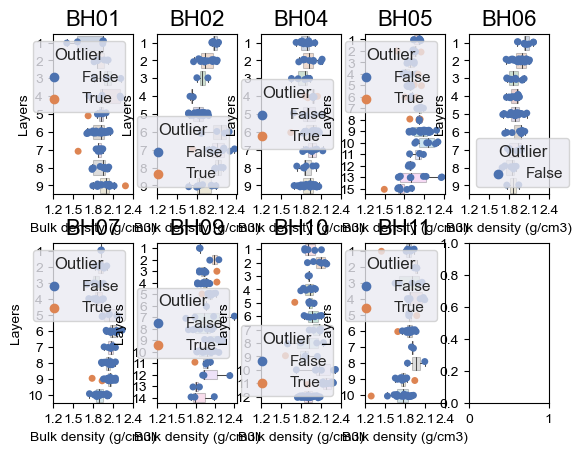

In [7]:
borehole_list = den_df["PointID"].unique()
borehole_list = [i for i in borehole_list if ("BH03" not in i) and ("BH08" not in i)] 
bh = 0
fig, axes = plt.subplots(2, 5)
#fig.suptitle('Distribution of bulk density by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 15)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = den_df[den_df["PointID"] == borehole_list[bh]]
            ax = sns.stripplot(data=filtered_df, x="Bulk density", y="Index", ax=axes[row, col], orient="h", hue="Outlier")
            ax = sns.boxplot(data=filtered_df, x="Bulk density", y="Index", ax=axes[row, col], orient="h", boxprops=dict(alpha=.3), linewidth=.75, showfliers= False)
            ax.set_title(borehole_list[bh][-4:], size=16)
            ax.set_xticks([i/10 for i in range(12, 25, 3)])
            ax.set_ylabel("Layers")
            ax.set_xlabel("Bulk density (g/cm3)")
            bh += 1

### Plot all BH 

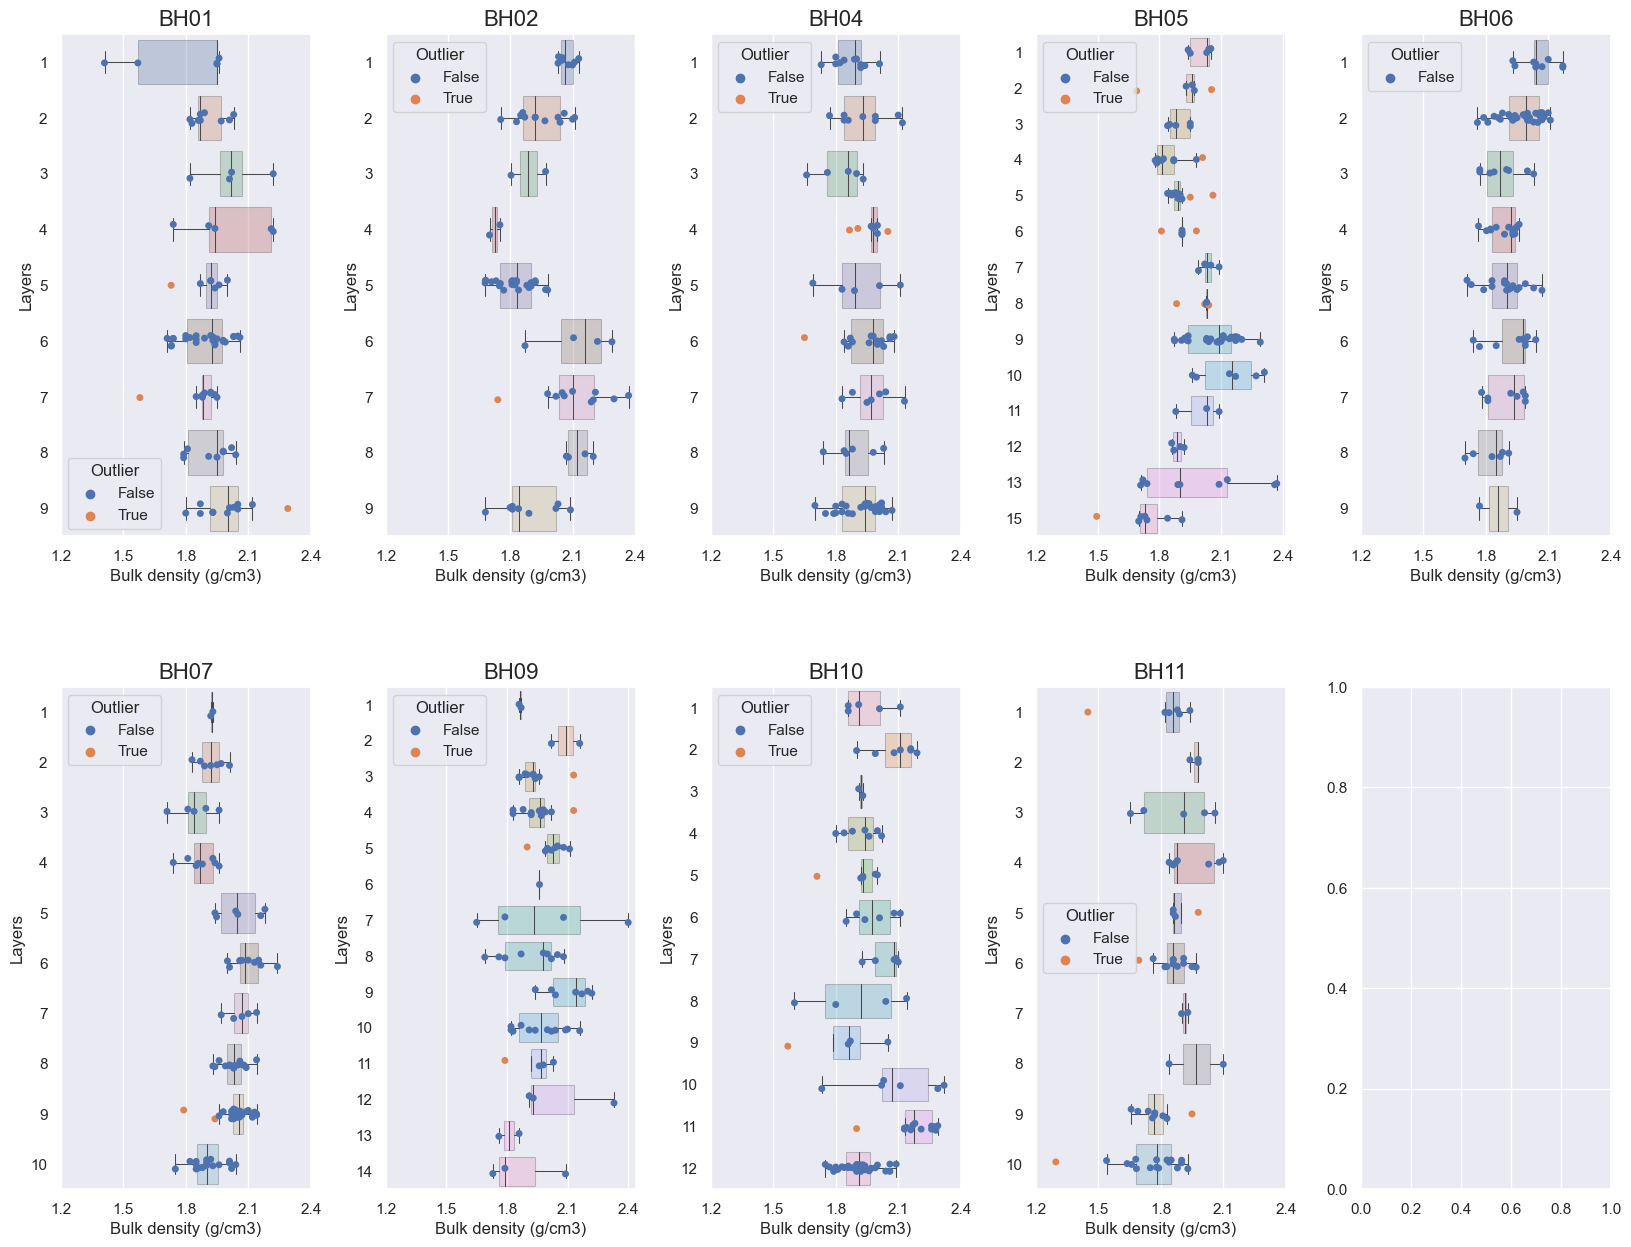

In [8]:
borehole_list = den_df["PointID"].unique()
borehole_list = [i for i in borehole_list if ("BH03" not in i) and ("BH08" not in i)] 
bh = 0
fig, axes = plt.subplots(2, 5)
#fig.suptitle('Distribution of bulk density by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 15)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = den_df[den_df["PointID"] == borehole_list[bh]]
            ax = sns.stripplot(data=filtered_df, x="Bulk density", y="Index", ax=axes[row, col], orient="h", hue="Outlier")
            ax = sns.boxplot(data=filtered_df, x="Bulk density", y="Index", ax=axes[row, col], orient="h", boxprops=dict(alpha=.3), linewidth=.75, showfliers= False)
            ax.set_title(borehole_list[bh][-4:], size=16)
            ax.set_xticks([i/10 for i in range(12, 25, 3)])
            ax.set_ylabel("Layers")
            ax.set_xlabel("Bulk density (g/cm3)")
            bh += 1

## Recalculate bulk density profile

#### BH03 and BH08 have missing data point so profile incomplete (not used in study)

In [9]:
geo_df["Mean BD (kn/m3)"] = geo_df.apply(lambda x: find_BD(den_stat, x.PointID, x.Index), axis=1)
geo_df["Cum BD (kn/m3)"] = geo_df.apply(lambda x: cumulative_BD(geo_df, x.PointID, x.Depth, x.Index), axis=1)
geo_df

544WTG23-BH02 10 10
544WTG23-BH03 2 2
544WTG23-BH03 3 3
544WTG23-BH03 10 10
544WTG23-BH03 11 11
544WTG23-BH03 12 12
544WTG23-BH03 13 13
544WTG23-BH05 14 14
544WTG23-BH08 1 1
544WTG23-BH08 13 13


,PointID,Top depth,Depth,Index,Mean BD (kn/m3),Cum BD (kn/m3)
0,544WTG23-BH01,0.00,2.80,1,19.11,0.00000
1,544WTG23-BH01,2.80,7.90,2,18.326,53.50800
2,544WTG23-BH01,7.90,10.60,3,19.7715,146.97060
3,544WTG23-BH01,10.60,12.55,4,19.6392,200.35365
4,544WTG23-BH01,12.55,16.00,5,18.816,238.65009
...,...,...,...,...,...,...
119,544WTG23-BH11,17.00,27.60,6,18.228,317.08912
120,544WTG23-BH11,27.60,29.00,7,18.767,510.30592
121,544WTG23-BH11,29.00,30.50,8,19.306,536.57972
122,544WTG23-BH11,30.50,36.50,9,17.346,565.53872


In [12]:
#geo_df.to_excel("data/BD profile_update.xlsx")